In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
import math
import datetime
import urllib.request
import requests
import json
import openmeteo_requests
import requests_cache
from retry_requests import retry


In [100]:
incs = pd.read_csv(r'Data_bomen/Incidenten_oorspronkelijk_volledig.csv')
incs = incs[incs['Damage_Type'] == 'Tree']

incs['Date_time'] = pd.to_datetime(incs['Date'] + ' ' + incs['Incident_Starttime'])
incs['Hour'] = incs['Date_time'].dt.strftime('%H')
incs['Date_time'] = incs['Date_time'].dt.strftime('%Y/%m/%d %H:%M')
incs = incs[['Incident_ID', 'Date', 'Incident_Starttime', 'Hour', 'Date_time', 'Incident_Endtime', 'Incident_Duration', 'Incident_Priority', 
             'Service_Area', 'Municipality', 'Damage_Type', 'LON', 'LAT']]

incs

,Incident_ID,Date,Incident_Starttime,Hour,Date_time,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,Damage_Type,LON,LAT
0,511,2018-09-07,08:25:18,08,2018/09/07 08:25,10:00:56,01:35:38,2.0,Amstelveen,Amstelveen,Tree,4.838685,52.281552
1,738,2018-09-10,16:46:38,16,2018/09/10 16:46,18:00:55,01:14:17,2.0,Victor,Amsterdam,Tree,4.930968,52.359724
4,1493,2018-09-21,06:59:05,06,2018/09/21 06:59,08:21:25,01:22:20,2.0,Amstelveen,Amstelveen,Tree,4.879741,52.301365
6,1502,2018-09-21,08:29:22,08,2018/09/21 08:29,10:06:43,01:37:21,2.0,Dirk,Amsterdam,Tree,4.870656,52.355189
7,1507,2018-09-21,09:25:55,09,2018/09/21 09:25,11:43:54,02:17:59,2.0,Teunis,Amsterdam,Tree,4.832333,52.380748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,443469,2023-11-02,19:06:07,19,2023/11/02 19:06,19:06:38,00:00:31,2.0,Weesp,Amsterdam,Tree,5.076108,52.299105
5731,443472,2023-11-02,19:45:17,19,2023/11/02 19:45,20:27:36,00:42:19,2.0,Willem,Amsterdam,Tree,4.908217,52.326775
5732,443474,2023-11-02,19:53:02,19,2023/11/02 19:53,23:41:51,03:48:49,2.0,Pieter,Amsterdam,Tree,4.822130,52.342331
5733,443476,2023-11-02,20:00:19,20,2023/11/02 20:00,20:52:15,00:51:56,2.0,Osdorp,Amsterdam,Tree,4.787237,52.362777


In [18]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.340147,
	"longitude":4.886314,
	"start_date": "2023-11-17",
	"end_date": "2023-11-17",
	"hourly": "wind_speed_10m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["wind_speed_10m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 52.337432861328125°E 4.833333492279053°N
Elevation 12.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                  date  wind_speed_10m
0  2023-11-17 00:00:00        3.758510
1  2023-11-17 01:00:00        3.396233
2  2023-11-17 02:00:00        7.145796
3  2023-11-17 03:00:00        5.804825
4  2023-11-17 04:00:00        6.151683
5  2023-11-17 05:00:00        6.034700
6  2023-11-17 06:00:00        7.895416
7  2023-11-17 07:00:00        5.815978
8  2023-11-17 08:00:00        5.588703
9  2023-11-17 09:00:00        6.830519
10 2023-11-17 10:00:00        7.517021
11 2023-11-17 11:00:00        9.339208
12 2023-11-17 12:00:00        6.489992
13 2023-11-17 13:00:00       10.703569
14 2023-11-17 14:00:00        9.449572
15 2023-11-17 15:00:00        7.421590
16 2023-11-17 16:00:00        5.904439
17 2023-11-17 17:00:00        6.034700
18 2023-11-17 18:00:00        6.519877
19 2023-11-17 19:00:00        8.707238
20 2023-11-17 20:00:00        9.531505
21 2023-11-17 21

In [101]:
# Read your incident data
incs = pd.read_csv(r'Data_bomen/Incidenten_oorspronkelijk_volledig.csv')
incs = incs[incs['Damage_Type'] == 'Tree']

incs['Date_time'] = pd.to_datetime(incs['Date'] + ' ' + incs['Incident_Starttime'])
incs['Hour'] = incs['Date_time'].dt.strftime('%H')
incs['Date_time'] = incs['Date_time'].dt.strftime('%Y/%m/%d %H:%M')
incs = incs[['Incident_ID', 'Date', 'Incident_Starttime', 'Hour', 'Date_time', 'Incident_Endtime', 'Incident_Duration', 'Incident_Priority', 
             'Service_Area', 'Municipality', 'Damage_Type', 'LON', 'LAT']]

# Split the DataFrame into 10 smaller DataFrames
num_splits = 10
incs_splits = np.array_split(incs, num_splits)


Split 1:


C:\Users\Aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,Incident_ID,Date,Incident_Starttime,Hour,Date_time,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,Damage_Type,LON,LAT
0,511,2018-09-07,08:25:18,08,2018/09/07 08:25,10:00:56,01:35:38,2.0,Amstelveen,Amstelveen,Tree,4.838685,52.281552
1,738,2018-09-10,16:46:38,16,2018/09/10 16:46,18:00:55,01:14:17,2.0,Victor,Amsterdam,Tree,4.930968,52.359724
4,1493,2018-09-21,06:59:05,06,2018/09/21 06:59,08:21:25,01:22:20,2.0,Amstelveen,Amstelveen,Tree,4.879741,52.301365
6,1502,2018-09-21,08:29:22,08,2018/09/21 08:29,10:06:43,01:37:21,2.0,Dirk,Amsterdam,Tree,4.870656,52.355189
7,1507,2018-09-21,09:25:55,09,2018/09/21 09:25,11:43:54,02:17:59,2.0,Teunis,Amsterdam,Tree,4.832333,52.380748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,98966,2010-08-17,17:04:52,17,2010/08/17 17:04,18:01:06,00:56:14,2.0,Osdorp,AMSTERDAM,Tree,4.814519,52.378362
615,98994,2010-08-18,18:03:46,18,2010/08/18 18:03,18:27:20,00:23:34,3.0,Hendrik,AMSTERDAM,Tree,4.848763,52.364241
616,99073,2010-08-21,11:56:18,11,2010/08/21 11:56,13:58:56,02:02:38,1.0,IJsbrand,AMSTERDAM,Tree,4.912897,52.402183
617,99150,2010-08-23,10:53:10,10,2010/08/23 10:53,11:15:52,00:22:42,3.0,Hendrik,AMSTERDAM,Tree,4.888731,52.367724


In [102]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [144]:
split = 9

In [145]:
temperature_2m_list = []
relative_humidity_2m_list = []
dew_point_2m_list = []
apparent_temperature_list = []
precipitation_list = []
rain_list = []
snowfall_list = []
snow_depth_list = []
weather_code_list = []
pressure_msl_list = []
surface_pressure_list = []
cloud_cover_list = []
cloud_cover_low_list = []
cloud_cover_mid_list = []
cloud_cover_high_list = []
et0_fao_evapotranspiration_list = []
vapour_pressure_deficit_list = []
wind_speed_10m_list = []
wind_speed_100m_list = []
wind_direction_10m_list = []
wind_direction_100m_list = []
wind_gusts_10m_list = []
soil_temperature_0_to_7cm_list = []
soil_temperature_7_to_28cm_list = []
soil_temperature_28_to_100cm_list = []
soil_temperature_100_to_255cm_list = []
soil_moisture_0_to_7cm_list = []
soil_moisture_7_to_28cm_list = []
soil_moisture_28_to_100cm_list = []
soil_moisture_100_to_255cm_list = []

for i, row in incs_splits[split].iterrows():
    latitude = row['LAT']
    longitude = row['LON']
    IncidentID = row['Incident_ID']
    DamageType = row['Damage_Type']
    dateStr = row['Date']
    timeStr = row['Hour']

    latitude='{:.5f}'.format(latitude)
    longitude='{:.5f}'.format(longitude)

    
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": dateStr,
        "end_date": dateStr,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "et0_fao_evapotranspiration", "vapour_pressure_deficit", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_temperature_100_to_255cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", "soil_moisture_100_to_255cm"]
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    temperature_2m = hourly.Variables(0).ValuesAsNumpy()[int(timeStr)]
    relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()[int(timeStr)]
    dew_point_2m = hourly.Variables(2).ValuesAsNumpy()[int(timeStr)]
    apparent_temperature = hourly.Variables(3).ValuesAsNumpy()[int(timeStr)]
    precipitation = hourly.Variables(4).ValuesAsNumpy()[int(timeStr)]
    rain = hourly.Variables(5).ValuesAsNumpy()[int(timeStr)]
    snowfall = hourly.Variables(6).ValuesAsNumpy()[int(timeStr)]
    snow_depth = hourly.Variables(7).ValuesAsNumpy()[int(timeStr)]
    weather_code = hourly.Variables(8).ValuesAsNumpy()[int(timeStr)]
    pressure_msl = hourly.Variables(9).ValuesAsNumpy()[int(timeStr)]
    surface_pressure = hourly.Variables(10).ValuesAsNumpy()[int(timeStr)]
    cloud_cover = hourly.Variables(11).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_low = hourly.Variables(12).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_mid = hourly.Variables(13).ValuesAsNumpy()[int(timeStr)]
    cloud_cover_high = hourly.Variables(14).ValuesAsNumpy()[int(timeStr)]
    et0_fao_evapotranspiration = hourly.Variables(15).ValuesAsNumpy()[int(timeStr)]
    vapour_pressure_deficit = hourly.Variables(16).ValuesAsNumpy()[int(timeStr)]
    wind_speed_10m = hourly.Variables(17).ValuesAsNumpy()[int(timeStr)]
    wind_speed_100m = hourly.Variables(18).ValuesAsNumpy()[int(timeStr)]
    wind_direction_10m = hourly.Variables(19).ValuesAsNumpy()[int(timeStr)]
    wind_direction_100m = hourly.Variables(20).ValuesAsNumpy()[int(timeStr)]
    wind_gusts_10m = hourly.Variables(21).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_0_to_7cm = hourly.Variables(22).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_7_to_28cm = hourly.Variables(23).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_28_to_100cm = hourly.Variables(24).ValuesAsNumpy()[int(timeStr)]
    soil_temperature_100_to_255cm = hourly.Variables(25).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_0_to_7cm = hourly.Variables(26).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_7_to_28cm = hourly.Variables(27).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_28_to_100cm = hourly.Variables(28).ValuesAsNumpy()[int(timeStr)]
    soil_moisture_100_to_255cm = hourly.Variables(29).ValuesAsNumpy()[int(timeStr)]
    

    temperature_2m_list.append(temperature_2m)
    relative_humidity_2m_list.append(relative_humidity_2m)
    dew_point_2m_list.append(dew_point_2m)
    apparent_temperature_list.append(apparent_temperature)
    precipitation_list.append(precipitation)
    rain_list.append(rain)
    snowfall_list.append(snowfall)
    snow_depth_list.append(snow_depth)
    weather_code_list.append(weather_code)
    pressure_msl_list.append(pressure_msl)
    surface_pressure_list.append(surface_pressure)
    cloud_cover_list.append(cloud_cover)
    cloud_cover_low_list.append(cloud_cover_low)
    cloud_cover_mid_list.append(cloud_cover_mid)
    cloud_cover_high_list.append(cloud_cover_high)
    et0_fao_evapotranspiration_list.append(et0_fao_evapotranspiration)
    vapour_pressure_deficit_list.append(vapour_pressure_deficit)
    wind_speed_10m_list.append(wind_speed_10m)
    wind_speed_100m_list.append(wind_speed_100m)
    wind_direction_10m_list.append(wind_direction_10m)
    wind_direction_100m_list.append(wind_direction_100m)
    wind_gusts_10m_list.append(wind_gusts_10m)
    soil_temperature_0_to_7cm_list.append(soil_temperature_0_to_7cm)
    soil_temperature_7_to_28cm_list.append(soil_temperature_7_to_28cm)
    soil_temperature_28_to_100cm_list.append(soil_temperature_28_to_100cm)
    soil_temperature_100_to_255cm_list.append(soil_temperature_100_to_255cm)
    soil_moisture_0_to_7cm_list.append(soil_moisture_0_to_7cm)
    soil_moisture_7_to_28cm_list.append(soil_moisture_7_to_28cm)
    soil_moisture_28_to_100cm_list.append(soil_moisture_28_to_100cm)
    soil_moisture_100_to_255cm_list.append(soil_moisture_100_to_255cm)


# Assign lists as new columns to the DataFrame
incs_splits[split]['temperature_2m'] = temperature_2m_list
incs_splits[split]['relative_humidity_2m'] = relative_humidity_2m_list
incs_splits[split]['dew_point_2m'] = dew_point_2m_list
incs_splits[split]['apparent_temperature'] = apparent_temperature_list
incs_splits[split]['precipitation'] = precipitation_list
incs_splits[split]['rain'] = rain_list
incs_splits[split]['snowfall'] = snowfall_list
incs_splits[split]['snow_depth'] = snow_depth_list
incs_splits[split]['weather_code'] = weather_code_list
incs_splits[split]['pressure_msl'] = pressure_msl_list
incs_splits[split]['surface_pressure'] = surface_pressure_list
incs_splits[split]['cloud_cover'] = cloud_cover_list
incs_splits[split]['cloud_cover_low'] = cloud_cover_low_list
incs_splits[split]['cloud_cover_mid'] = cloud_cover_mid_list
incs_splits[split]['cloud_cover_high'] = cloud_cover_high_list
incs_splits[split]['et0_fao_evapotranspiration'] = et0_fao_evapotranspiration_list
incs_splits[split]['vapour_pressure_deficit'] = vapour_pressure_deficit_list
incs_splits[split]['wind_speed_10m'] = wind_speed_10m_list
incs_splits[split]['wind_speed_100m'] = wind_speed_100m_list
incs_splits[split]['wind_direction_10m'] = wind_direction_10m_list
incs_splits[split]['wind_direction_100m'] = wind_direction_100m_list
incs_splits[split]['wind_gusts_10m'] = wind_gusts_10m_list
incs_splits[split]['soil_temperature_0_to_7cm'] = soil_temperature_0_to_7cm_list
incs_splits[split]['soil_temperature_7_to_28cm'] = soil_temperature_7_to_28cm_list
incs_splits[split]['soil_temperature_28_to_100cm'] = soil_temperature_28_to_100cm_list
incs_splits[split]['soil_temperature_100_to_255cm'] = soil_temperature_100_to_255cm_list
incs_splits[split]['soil_moisture_0_to_7cm'] = soil_moisture_0_to_7cm_list
incs_splits[split]['soil_moisture_7_to_28cm'] = soil_moisture_7_to_28cm_list
incs_splits[split]['soil_moisture_28_to_100cm'] = soil_moisture_28_to_100cm_list
incs_splits[split]['soil_moisture_100_to_255cm'] = soil_moisture_100_to_255cm_list


In [147]:
combined_incs = pd.concat(incs_splits, ignore_index=True)
combined_incs

,Incident_ID,Date,Incident_Starttime,Hour,Date_time,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,...,wind_direction_100m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,511,2018-09-07,08:25:18,08,2018/09/07 08:25,10:00:56,01:35:38,2.0,Amstelveen,Amstelveen,...,275.194336,34.560001,15.537001,16.786999,17.337000,16.687000,0.386,0.347,0.244,0.340
1,738,2018-09-10,16:46:38,16,2018/09/10 16:46,18:00:55,01:14:17,2.0,Victor,Amsterdam,...,255.579193,37.079998,18.304501,16.854500,16.504499,13.704500,0.527,0.484,0.459,0.617
2,1493,2018-09-21,06:59:05,06,2018/09/21 06:59,08:21:25,01:22:20,2.0,Amstelveen,Amstelveen,...,218.607651,83.879997,17.693501,18.243500,16.843500,16.693501,0.320,0.285,0.253,0.337
3,1502,2018-09-21,08:29:22,08,2018/09/21 08:29,10:06:43,01:37:21,2.0,Dirk,Amsterdam,...,259.234283,70.919998,16.885000,17.684999,15.885000,13.785001,0.580,0.548,0.494,0.623
4,1507,2018-09-21,09:25:55,09,2018/09/21 09:25,11:43:54,02:17:59,2.0,Teunis,Amsterdam,...,262.199890,64.799995,16.930500,17.730499,15.930500,13.880500,0.521,0.498,0.465,0.619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,443469,2023-11-02,19:06:07,19,2023/11/02 19:06,19:06:38,00:00:31,2.0,Weesp,Amsterdam,...,200.949783,82.079994,10.495500,11.345500,12.845500,14.045500,0.732,0.737,0.724,0.635
2421,443472,2023-11-02,19:45:17,19,2023/11/02 19:45,20:27:36,00:42:19,2.0,Willem,Amsterdam,...,199.290146,81.720001,9.700000,11.150000,12.850000,14.000000,0.740,0.743,0.708,0.632
2422,443474,2023-11-02,19:53:02,19,2023/11/02 19:53,23:41:51,03:48:49,2.0,Pieter,Amsterdam,...,199.290146,81.720001,9.674000,11.124000,12.824000,13.974000,0.740,0.743,0.708,0.632
2423,443476,2023-11-02,20:00:19,20,2023/11/02 20:00,20:52:15,00:51:56,2.0,Osdorp,Amsterdam,...,201.015884,80.639999,9.650000,11.100000,12.850000,14.000000,0.740,0.742,0.709,0.632


In [148]:
combined_incs.to_csv('incidents+weather.csv', index=False)

In [185]:
incidenten = pd.read_csv(r'data_bomen/Stormdata & FireStations geadresseerd.csv')
incidenten_sorted = incidenten[incidenten['Damage_Type'] == 'Tree']
incidenten_sorted = incidenten_sorted.drop('Unnamed: 0', axis=1)
incidenten_sorted

,Incident_ID,Incident_Starttime,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Damage_Type,Municipality,LON,LAT,Day,Month,Year,City,Suburb,Residential,Road,Zipcode
0,511,08:25:18,10:00:56,95.633,2.0,Amstelveen,Tree,Amstelveen,4.838685,52.281552,7,9,2018,NaN,NaN,NaN,Bouwerij,1185 XW
1,738,16:46:38,18:00:55,74.283,2.0,Victor,Tree,Amsterdam,4.930968,52.359724,10,9,2018,Amsterdam,Oost,Dapperbuurt,Linnaeusplantsoen,1093 KL
4,1493,06:59:05,08:21:25,82.333,2.0,Amstelveen,Tree,Amstelveen,4.879741,52.301365,21,9,2018,NaN,NaN,NaN,Oranjebaan,1183 PL
5,1502,08:29:22,10:06:43,97.350,2.0,Dirk,Tree,Amsterdam,4.870656,52.355189,21,9,2018,Amsterdam,Zuid,Museumkwartier,Van Breestraat,1071 ZM
6,1507,09:25:55,11:43:54,137.983,2.0,Teunis,Tree,Amsterdam,4.832333,52.380748,21,9,2018,Amsterdam,Nieuw-West,NaN,M.C. Addicksstraat,1063 VZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,436479,18:47:00,20:36:09,109.150,5.0,Victor,Tree,Amsterdam,4.944491,52.352064,31,7,2023,Amsterdam,Oost,Middenmeer,Rutherfordstraat,1098 TM
5277,436603,14:10:34,15:13:30,62.933,2.0,Osdorp,Tree,Amsterdam,4.824533,52.376163,2,8,2023,Amsterdam,Nieuw-West,NaN,Louis Couperusstraat,1064 CE
5282,436834,03:38:27,06:29:11,170.733,5.0,Nico,Tree,Amsterdam,4.928197,52.390568,6,8,2023,Amsterdam,Noord,Tuindorp Buiksloot,Nieuwendammerdijk,1025 LP
5283,436904,21:52:41,22:16:29,23.800,2.0,Nico,Tree,Amsterdam,4.917106,52.368343,6,8,2023,Amsterdam,Centrum,NaN,Hoogte Kadijk,1018 BV


In [186]:
df = pd.read_csv(r'incidents+weather.csv')
# Create a map centered around Amsterdam
amsterdam_map = folium.Map(location=[52.3676, 4.9041], zoom_start=12)

# Create a MarkerCluster to add incidents to the map
marker_cluster = MarkerCluster().add_to(amsterdam_map)

# Add markers for each incident
for index, incident in df.iterrows():
    # Extract incident details
    incident_id = incident['Incident_ID']
    lat = incident['LAT']
    lon = incident['LON']
    damage_type = incident['Damage_Type']
    priority = incident['Incident_Priority']

    # Create a popup for the marker
    popup_text = f"Incident ID: {incident_id}<br>Damage Type: {damage_type}<br>Priority: {priority}"

    # Add marker to the cluster
    folium.Marker(location=[lat, lon], popup=popup_text).add_to(marker_cluster)

# Save the map as an HTML file
amsterdam_map.save("incident_map.html")


In [151]:
trees = pd.read_csv(r'data_bomen\BOMEN_DATA_WITH_ZIP.csv')
trees = trees.drop('Unnamed: 0', axis=1)
trees.head()

,OBJECTNUMMER,id,soortnaam,soortnaamKort,SoortnaamNL,soortnaamTop,boomhoogteklasseActueel,stamdiameterklasse,jaarVanAanleg,typeObject,...,typeBeheerderPlus,typeEigenaarPlus,SDVIEW,RADIUS,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,Zipcode,Zip4
0,1,919934,Ulmus hollandica `Vegeta`,Ulmus,Huntingdon-iep,Iep (Ulmus),b. 6 tot 9 m.,NaN,1978,Boom niet vrij uitgroeiend,...,Stadsdeel Zuid,Gemeente Amsterdam,K,2,POINT(4.9026919 52.340093),POINT(52.340093 4.9026919),4.902692,52.340093,1185 XW,1185
1,2,919935,Fraxinus excelsior `Westhof`s Glorie`,Fraxinus,Gewone es (cultuurvariëteit),Es (Fraxinus),c. 9 tot 12 m.,"0,2 tot 0,3 m.",1990,Boom niet vrij uitgroeiend,...,Stadsdeel Zuid,Gemeente Amsterdam,K,3,POINT(4.8552081 52.331984),POINT(52.331984 4.8552081),4.855208,52.331984,1185 XW,1185
2,3,919936,Ulmus glabra `Lutescens`,Ulmus,Gele bergiep (cultuurvariëteit),Iep (Ulmus),b. 6 tot 9 m.,NaN,2002,Boom niet vrij uitgroeiend,...,Stadsdeel Zuid,Gemeente Amsterdam,K,2,POINT(4.9036699 52.348837),POINT(52.348837 4.9036699),4.903670,52.348837,1185 XW,1185
3,4,919937,Quercus robur,Quercus,Zomereik,Eik (Quercus),b. 6 tot 9 m.,NaN,1985,Boom niet vrij uitgroeiend,...,Stadsdeel Zuid,Gemeente Amsterdam,K,2,POINT(4.875886 52.341056),POINT(52.341056 4.875886),4.875886,52.341056,1185 XW,1185
4,5,919939,Styphnolobium japonicum,Overig,Honingboom,Styphnolobium,a. tot 6 m.,NaN,2002,Boom niet vrij uitgroeiend,...,Stadsdeel Zuid,Gemeente Amsterdam,K,1,POINT(4.8803689 52.332891),POINT(52.332891 4.8803689),4.880369,52.332891,1185 XW,1185


In [166]:
incidenten = pd.read_csv(r'data_bomen/Stormdata & FireStations geadresseerd.csv')
incidenten_sorted = incidenten[incidenten['Damage_Type'] == 'Tree']
incidenten_sorted = incidenten_sorted.drop('Unnamed: 0', axis=1)
incidenten_sorted = incidenten_sorted[['Incident_ID', 'Suburb', 'Residential', 'Road', 'Zipcode']]
incidenten_sorted

,Incident_ID,Suburb,Residential,Road,Zipcode
0,511,NaN,NaN,Bouwerij,1185 XW
1,738,Oost,Dapperbuurt,Linnaeusplantsoen,1093 KL
4,1493,NaN,NaN,Oranjebaan,1183 PL
5,1502,Zuid,Museumkwartier,Van Breestraat,1071 ZM
6,1507,Nieuw-West,NaN,M.C. Addicksstraat,1063 VZ
...,...,...,...,...,...
5276,436479,Oost,Middenmeer,Rutherfordstraat,1098 TM
5277,436603,Nieuw-West,NaN,Louis Couperusstraat,1064 CE
5282,436834,Noord,Tuindorp Buiksloot,Nieuwendammerdijk,1025 LP
5283,436904,Centrum,NaN,Hoogte Kadijk,1018 BV


In [168]:
merged_df = pd.merge(df, incidenten_sorted[['Incident_ID', 'Suburb', 'Residential', 'Road', 'Zipcode']], on='Incident_ID', how='left')
merged_df
merged_df.to_csv('incidents+weather.csv', index=False)

In [11]:
df = pd.read_csv(r'data_bomen/incidents_weather_geo.csv')
pd.set_option('display.max_rows', None)
print(df.to_string(index=False))
pd.reset_option('display.max_rows')

 Unnamed: 0  Incident_ID       Date Incident_Starttime  Hour        Date_time Incident_Endtime Incident_Duration  Incident_Priority              Service_Area Municipality Damage_Type      LON       LAT  temperature_2m  relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  rain  snowfall  snow_depth  weather_code  pressure_msl  surface_pressure  cloud_cover  cloud_cover_low  cloud_cover_mid  cloud_cover_high  et0_fao_evapotranspiration  vapour_pressure_deficit  wind_speed_10m  wind_speed_100m  wind_direction_10m  wind_direction_100m  wind_gusts_10m  soil_temperature_0_to_7cm  soil_temperature_7_to_28cm  soil_temperature_28_to_100cm  soil_temperature_100_to_255cm  soil_moisture_0_to_7cm  soil_moisture_7_to_28cm  soil_moisture_28_to_100cm  soil_moisture_100_to_255cm     Suburb             Residential                             Road Zipcode                                  location  grid_id
          1          738 2018-09-10           16:46:38    16 2018/09/10 16:46   

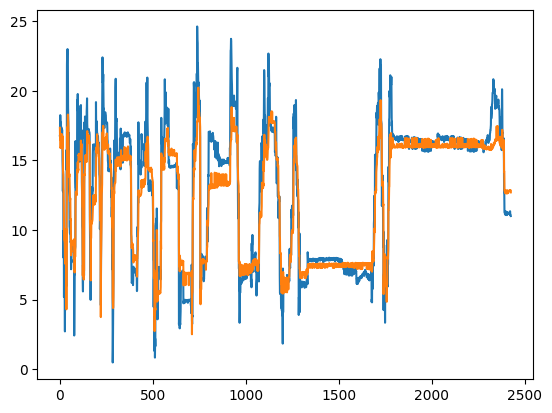

In [179]:
plt.plot(df['soil_temperature_7_to_28cm'])
plt.plot(df['soil_temperature_28_to_100cm'])